In [1]:
!pip install faker

In [60]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [128]:
m = 30000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 30000/30000 [00:01<00:00, 21944.17it/s]


In [76]:
print(dataset[10000:11000])
print(len(dataset))

[]
10000


In [129]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)


#X_test, Y_test, Xoh_test, Yoh_test = preprocess_data(dataset[10000:20000], human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (30000, 30)
Y.shape: (30000, 10)
Xoh.shape: (30000, 30, 37)
Yoh.shape: (30000, 10, 11)


In [132]:
print("X.shape:", X_test.shape)
print("Y.shape:", Y_test.shape)
print("Xoh.shape:", Xoh_test.shape)
print("Yoh.shape:", Yoh_test.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [133]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):\n", X[index])
print("Target after preprocessing (indices):\n", Y[index])
print()
print("Source after preprocessing (one-hot):\n", Xoh[index])
print("Target after preprocessing (one-hot):\n", Yoh[index])

Source date: 4/11/16
Target date: 2016-04-11

Source after preprocessing (indices):
 [ 7  2  4  4  2  4  9 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices):
 [3 1 2 7 0 1 5 0 2 2]

Source after preprocessing (one-hot):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot):
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [134]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [135]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev) 
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a,s_prev]) 
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat) 
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e) 
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies) 
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a]) 
    ### END CODE HERE ###
    
    return context

In [136]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [137]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True),input_shape=(m, Tx, n_a*2))(X)  
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context,initial_state = [s, c] ) 
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [138]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [139]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999,decay=0.01) 
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
### END CODE HERE ###

In [140]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))
outputs_test = list(Yoh_test.swapaxes(0,1))


In [141]:
history = model.fit([Xoh, s0, c0], outputs, validation_split=0.33 , epochs=40, batch_size=512)

Epoch 1/40
40/40 [==============================] - 18s 455ms/step - loss: 19.2160 - dense_14_loss: 1.4426 - dense_14_1_loss: 1.3437 - dense_14_2_loss: 2.0193 - dense_14_3_loss: 2.8076 - dense_14_4_loss: 1.1472 - dense_14_5_loss: 1.6253 - dense_14_6_loss: 2.7466 - dense_14_7_loss: 1.3949 - dense_14_8_loss: 1.8927 - dense_14_9_loss: 2.7959 - dense_14_accuracy: 0.4762 - dense_14_1_accuracy: 0.5553 - dense_14_2_accuracy: 0.2344 - dense_14_3_accuracy: 0.0546 - dense_14_4_accuracy: 0.8919 - dense_14_5_accuracy: 0.0929 - dense_14_6_accuracy: 0.0224 - dense_14_7_accuracy: 0.7602 - dense_14_8_accuracy: 0.1480 - dense_14_9_accuracy: 0.0691 - val_loss: 14.6157 - val_dense_14_loss: 0.4860 - val_dense_14_1_loss: 0.4824 - val_dense_14_2_loss: 1.4007 - val_dense_14_3_loss: 2.7943 - val_dense_14_4_loss: 0.4725 - val_dense_14_5_loss: 1.1191 - val_dense_14_6_loss: 2.7596 - val_dense_14_7_loss: 0.9445 - val_dense_14_8_loss: 1.5658 - val_dense_14_9_loss: 2.5908 - val_dense_14_accuracy: 0.9172 - val_dense

In [142]:
print(history.history.keys())

dict_keys(['loss', 'dense_14_loss', 'dense_14_1_loss', 'dense_14_2_loss', 'dense_14_3_loss', 'dense_14_4_loss', 'dense_14_5_loss', 'dense_14_6_loss', 'dense_14_7_loss', 'dense_14_8_loss', 'dense_14_9_loss', 'dense_14_accuracy', 'dense_14_1_accuracy', 'dense_14_2_accuracy', 'dense_14_3_accuracy', 'dense_14_4_accuracy', 'dense_14_5_accuracy', 'dense_14_6_accuracy', 'dense_14_7_accuracy', 'dense_14_8_accuracy', 'dense_14_9_accuracy', 'val_loss', 'val_dense_14_loss', 'val_dense_14_1_loss', 'val_dense_14_2_loss', 'val_dense_14_3_loss', 'val_dense_14_4_loss', 'val_dense_14_5_loss', 'val_dense_14_6_loss', 'val_dense_14_7_loss', 'val_dense_14_8_loss', 'val_dense_14_9_loss', 'val_dense_14_accuracy', 'val_dense_14_1_accuracy', 'val_dense_14_2_accuracy', 'val_dense_14_3_accuracy', 'val_dense_14_4_accuracy', 'val_dense_14_5_accuracy', 'val_dense_14_6_accuracy', 'val_dense_14_7_accuracy', 'val_dense_14_8_accuracy', 'val_dense_14_9_accuracy'])


In [143]:
labels = list(history.history.keys())

In [144]:
print(labels)

['loss', 'dense_14_loss', 'dense_14_1_loss', 'dense_14_2_loss', 'dense_14_3_loss', 'dense_14_4_loss', 'dense_14_5_loss', 'dense_14_6_loss', 'dense_14_7_loss', 'dense_14_8_loss', 'dense_14_9_loss', 'dense_14_accuracy', 'dense_14_1_accuracy', 'dense_14_2_accuracy', 'dense_14_3_accuracy', 'dense_14_4_accuracy', 'dense_14_5_accuracy', 'dense_14_6_accuracy', 'dense_14_7_accuracy', 'dense_14_8_accuracy', 'dense_14_9_accuracy', 'val_loss', 'val_dense_14_loss', 'val_dense_14_1_loss', 'val_dense_14_2_loss', 'val_dense_14_3_loss', 'val_dense_14_4_loss', 'val_dense_14_5_loss', 'val_dense_14_6_loss', 'val_dense_14_7_loss', 'val_dense_14_8_loss', 'val_dense_14_9_loss', 'val_dense_14_accuracy', 'val_dense_14_1_accuracy', 'val_dense_14_2_accuracy', 'val_dense_14_3_accuracy', 'val_dense_14_4_accuracy', 'val_dense_14_5_accuracy', 'val_dense_14_6_accuracy', 'val_dense_14_7_accuracy', 'val_dense_14_8_accuracy', 'val_dense_14_9_accuracy']


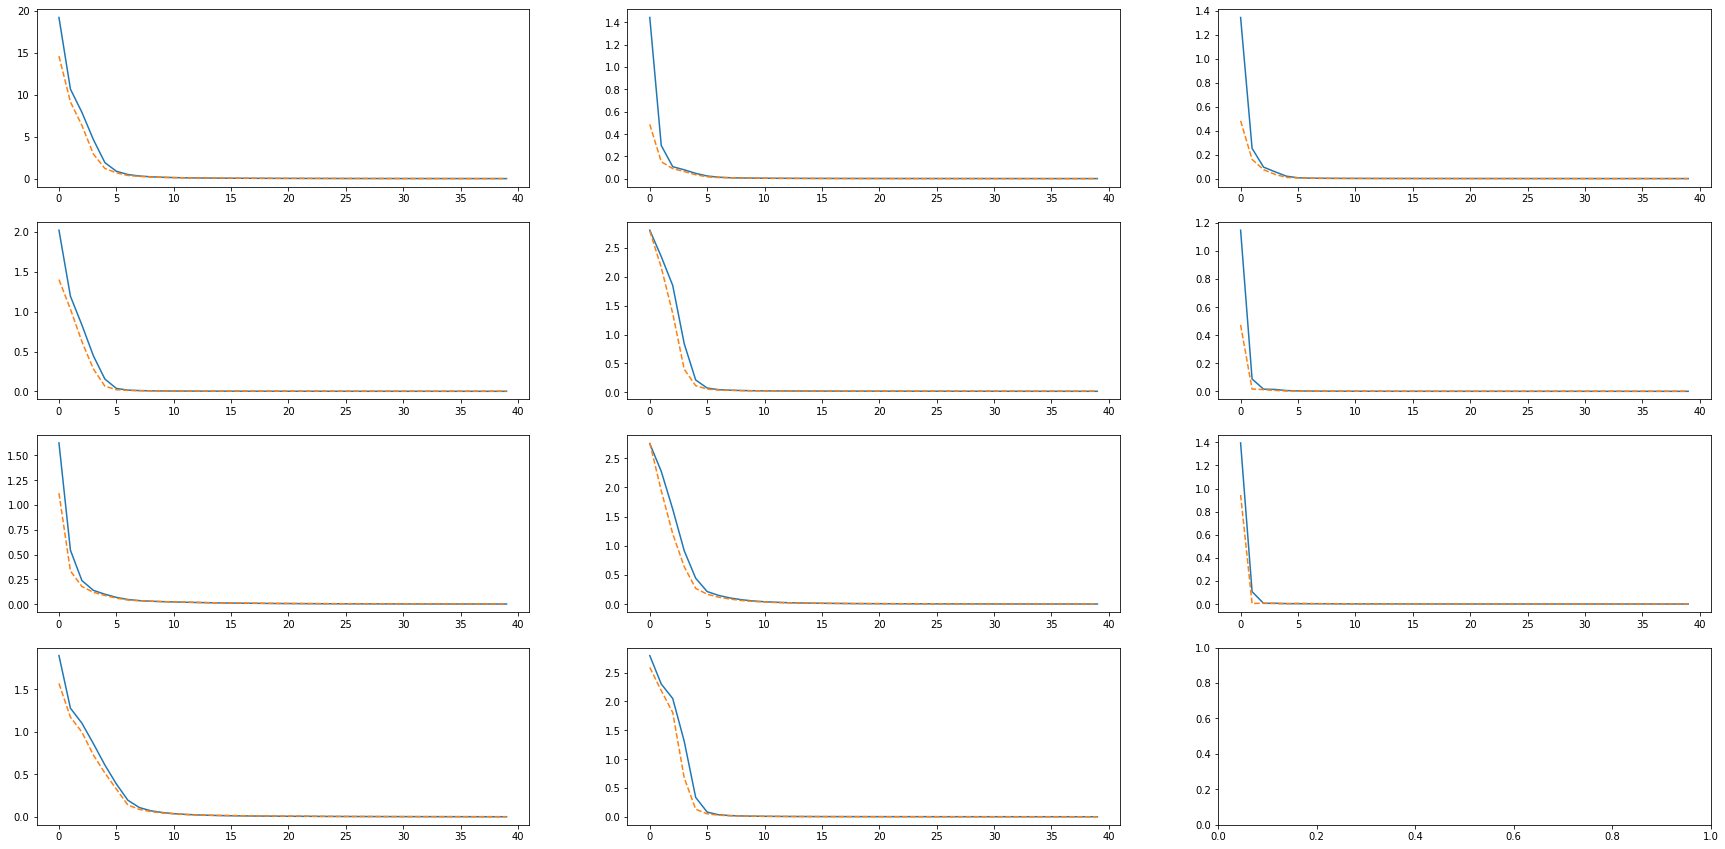

In [145]:
from matplotlib import pyplot as plt



#plt.figure(figsize=(50,50))
fig, axs = plt.subplots(4, 3 , figsize=(30,15))
#axs[0, 0].plot(x, y)
##axs[0, 0].set_title('Axis [0, 0]')
#axs[0, 1].plot(x, y, 'tab:orange')
#axs[0, 1].set_title('Axis [0, 1]')
#axs[1, 0].plot(x, -y, 'tab:green')
#axs[1, 0].set_title('Axis [1, 0]')
#axs[1, 1].plot(x, -y, 'tab:red')
#axs[1, 1].set_title('Axis [1, 1]')



axs[0, 0].plot(history.history['loss'] , label =labels[1] )
axs[0, 1].plot(history.history['dense_14_loss'])
axs[0, 2].plot(history.history['dense_14_1_loss'])
axs[1, 0].plot(history.history['dense_14_2_loss'])
axs[1, 1].plot(history.history['dense_14_3_loss'])
axs[1, 2].plot(history.history['dense_14_4_loss'])
axs[2, 0].plot(history.history['dense_14_5_loss'])
axs[2, 1].plot(history.history['dense_14_6_loss'])
axs[2, 2].plot(history.history['dense_14_7_loss'])
axs[3, 0].plot(history.history['dense_14_8_loss'])
axs[3, 1].plot(history.history['dense_14_9_loss'])

axs[0, 0].plot(history.history['val_loss'] , linestyle = '--' )
axs[0, 1].plot(history.history['val_dense_14_loss'], linestyle = '--')
axs[0, 2].plot(history.history['val_dense_14_1_loss'], linestyle = '--')
axs[1, 0].plot(history.history['val_dense_14_2_loss'],linestyle = '--')
axs[1, 1].plot(history.history['val_dense_14_3_loss'],linestyle = '--')
axs[1, 2].plot(history.history['val_dense_14_4_loss'],linestyle = '--')
axs[2, 0].plot(history.history['val_dense_14_5_loss'],linestyle = '--')
axs[2, 1].plot(history.history['val_dense_14_6_loss'],linestyle = '--')
axs[2, 2].plot(history.history['val_dense_14_7_loss'],linestyle = '--')
axs[3, 0].plot(history.history['val_dense_14_8_loss'],linestyle = '--')
axs[3, 1].plot(history.history['val_dense_14_9_loss'],linestyle = '--')
#axs[3, 2].title('model losses')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['loss', 'dense_2_loss' ,'dense_2_1_loss' ,  'dense_2_2_loss', 'dense_2_3_loss', 
#            'dense_2_4_loss', 'dense_2_5_loss', 'dense_2_6_loss', 'dense_2_7_loss',
#            'dense_2_8_loss', 'dense_2_9_loss'  ], loc='upper left')
#plt.show()

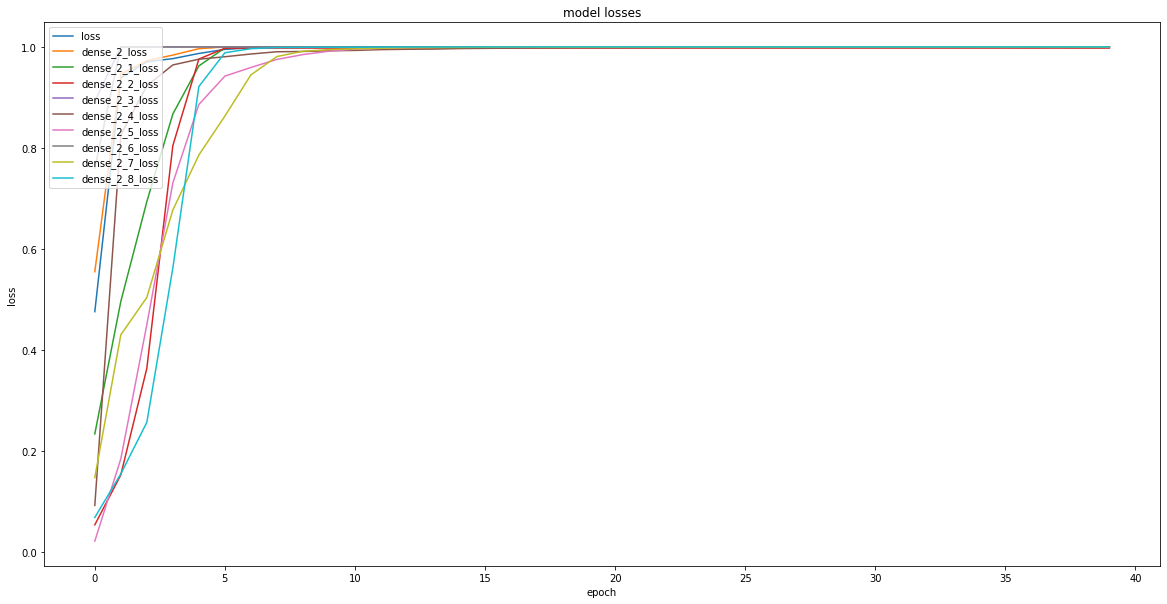

In [146]:
from matplotlib import pyplot as plt


plt.figure(figsize=(20,10))
#plt.plot(history.history['loss'])
plt.plot(history.history['dense_14_accuracy'])
plt.plot(history.history['dense_14_1_accuracy'])
plt.plot(history.history['dense_14_2_accuracy'])
plt.plot(history.history['dense_14_3_accuracy'])
plt.plot(history.history['dense_14_4_accuracy'])
plt.plot(history.history['dense_14_5_accuracy'])
plt.plot(history.history['dense_14_6_accuracy'])
plt.plot(history.history['dense_14_7_accuracy'])
plt.plot(history.history['dense_14_8_accuracy'])
plt.plot(history.history['dense_14_9_accuracy'])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'dense_2_loss' ,'dense_2_1_loss' ,  'dense_2_2_loss', 'dense_2_3_loss', 
            'dense_2_4_loss', 'dense_2_5_loss', 'dense_2_6_loss', 'dense_2_7_loss',
            'dense_2_8_loss', 'dense_2_9_loss'  ], loc='upper left')
plt.show()

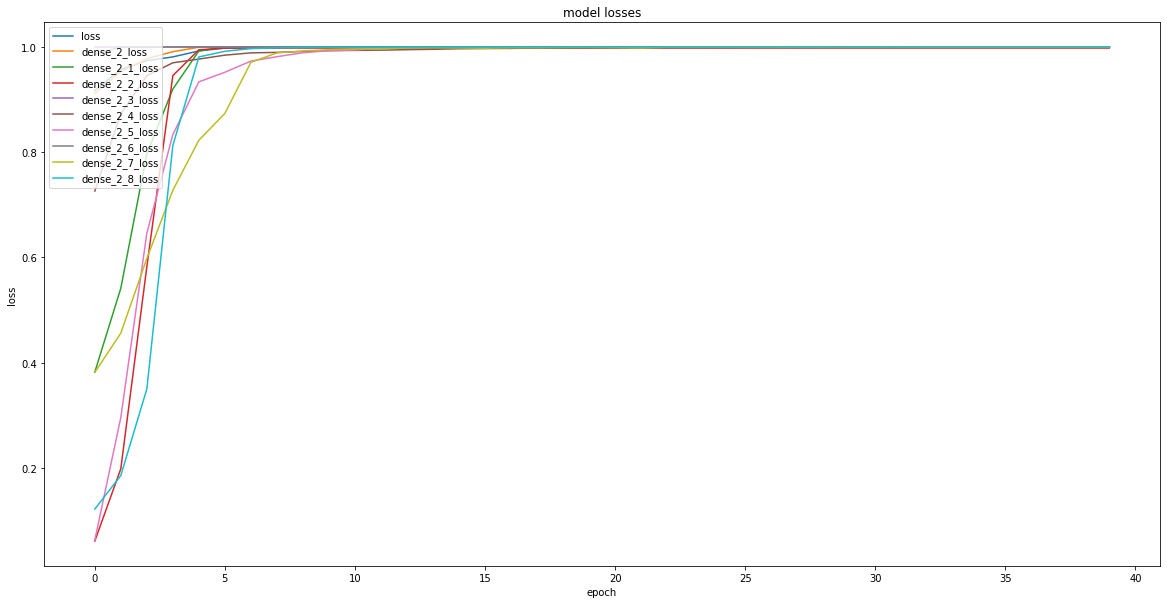

In [147]:
from matplotlib import pyplot as plt


plt.figure(figsize=(20,10))
#plt.plot(history.history['loss'])
plt.plot(history.history['val_dense_14_accuracy'])
plt.plot(history.history['val_dense_14_1_accuracy'])
plt.plot(history.history['val_dense_14_2_accuracy'])
plt.plot(history.history['val_dense_14_3_accuracy'])
plt.plot(history.history['val_dense_14_4_accuracy'])
plt.plot(history.history['val_dense_14_5_accuracy'])
plt.plot(history.history['val_dense_14_6_accuracy'])
plt.plot(history.history['val_dense_14_7_accuracy'])
plt.plot(history.history['val_dense_14_8_accuracy'])
plt.plot(history.history['val_dense_14_9_accuracy'])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'dense_2_loss' ,'dense_2_1_loss' ,  'dense_2_2_loss', 'dense_2_3_loss', 
            'dense_2_4_loss', 'dense_2_5_loss', 'dense_2_6_loss', 'dense_2_7_loss',
            'dense_2_8_loss', 'dense_2_9_loss'  ], loc='upper left')
plt.show()

In [148]:



EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
print(s0.shape)

s01 = np.zeros((1, n_s))
c01 = np.zeros((1, n_s))
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array([list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))])#.swapaxes(1,2)
    print(source.shape)

    prediction = model.predict([source, s01, c01])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))
    

(30000, 64)
(1, 30, 37)
source: 3 May 1979
output: 1979-05-03
(1, 30, 37)
source: 5 April 09
output: 2009-04-05
(1, 30, 37)
source: 21th of August 2016
output: 2016-08-21
(1, 30, 37)
source: Tue 10 Jul 2007
output: 2007-07-10
(1, 30, 37)
source: Saturday May 9 2018
output: 2018-05-09
(1, 30, 37)
source: March 3 2001
output: 2001-03-03
(1, 30, 37)
source: March 3rd 2001
output: 2001-03-03
(1, 30, 37)
source: 1 March 2001
output: 2001-03-01


<Figure size 432x288 with 0 Axes>

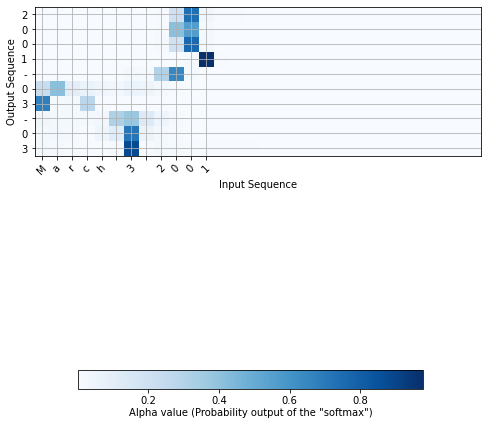

In [152]:

EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 
            'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001',
            'March 3rd 2001', '1 March 2001']

attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, EXAMPLES[5], num = 7, n_s = 64)

